In [1]:
import os
import requests
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Download Files

In [2]:
def download_files(urls, destination_folder = "/kaggle/working"):
    for url in urls:
        try:
            file_name = url.split('/')[-1]
            destination_path = f"{destination_folder}/{file_name}"
            response = requests.get(url, stream=True)

            if response.status_code == 200:
                with open(destination_path, 'wb') as file:
                    for chunk in response.iter_content(chunk_size=8192):
                        file.write(chunk)
                print(f"Downloaded : {destination_path}")
            else:
                print(f"Failed to download {url}. HTTP Status code: {response.status_code}")
        except Exception as e:
            print(f"Error downloading {url}: {e}")

In [3]:
base_dir = "/kaggle/working/"
base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
classes = ["airplane", "apple", "banana", "bird", "bicycle", "clock"]
labels = [i for i in range(len(classes))]  

In [4]:
urls = [f"{base_url + i}.npy" for i in classes]
download_files(urls)

Downloaded : /kaggle/working/airplane.npy
Downloaded : /kaggle/working/apple.npy
Downloaded : /kaggle/working/banana.npy
Downloaded : /kaggle/working/bird.npy
Downloaded : /kaggle/working/bicycle.npy
Downloaded : /kaggle/working/clock.npy


In [5]:
def load_npy_files(file_paths):
    data = []
    for file_path in file_paths:
        try:
            array = np.load(file_path)
            data.append(array)
            print(f"Loaded {file_path} successfully.")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return data

In [6]:
file_paths = [os.path.join(base_dir, f'{i}.npy') for i in classes]
loaded_data = load_npy_files(file_paths)

Loaded /kaggle/working/airplane.npy successfully.
Loaded /kaggle/working/apple.npy successfully.
Loaded /kaggle/working/banana.npy successfully.
Loaded /kaggle/working/bird.npy successfully.
Loaded /kaggle/working/bicycle.npy successfully.
Loaded /kaggle/working/clock.npy successfully.


In [7]:
# data
# [
#     [] app
#     [] air...
# ]

In [8]:
in_channels = 1 #greyscale imgs
batch_size = 64
num_classes = len(classes)
learning_rate = 1e-3
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.data = []
        self.labels = []
        
        for file_path, label in zip(file_paths, labels):
            try:
                array = np.load(file_path)
                self.data.append(array)
                self.labels.extend([label] * len(array))
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    def __len__(self):
        return sum(len(d) for d in self.data)

    def __getitem__(self, idx):
        cumulative_length = 0 
        for i, array in enumerate(self.data):
            if idx < cumulative_length + len(array):
                image = array[idx - cumulative_length]
                
                image = image.reshape(28, 28) 
                
                if len(image.shape) == 2:
#                     [[64, 28, 28]]
                    image = torch.from_numpy(image).unsqueeze(0)
#                     [[64, 1, 28, 28]]

                return (image, self.labels[idx])
            cumulative_length += len(array)


In [43]:
dataset = CustomDataset(file_paths, labels)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Loaders

In [44]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last = True)

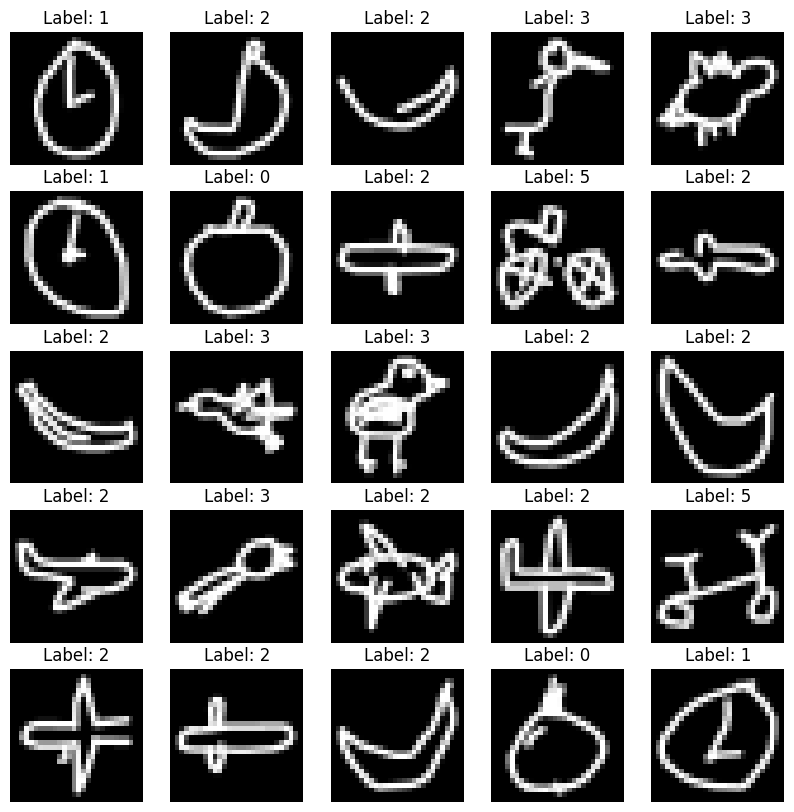

In [45]:
for images, labels in train_loader:
    plt.figure(figsize=(10, 10))
    for i in range(25):  
        image = images[i].squeeze(0).numpy()
        plt.subplot(5, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break


In [46]:
class CNN(nn.Module):
    def __init__(self, in_channels = in_channels, num_classes = num_classes ):
        super(CNN, self).__init__()
        
#         [45] [58]  
#         [22] [12] 

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14x14x5
            nn.Conv2d(5, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7x7x8
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU() # 7x7x16
        )
        
        self.linear = nn.Sequential(
            nn.Linear(7*7*16, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, num_classes)
        )
                
    
    def forward(self, x):
        out = self.conv(x) # [30, 20, 10]
        out = out.view(out.shape[0], -1) # [30, 200]
        out = self.linear(out)
        return out


In [60]:
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device).float()
            labels = labels.to(device)
            scores = model(data)

            _, predictions = scores.max(1)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)
    print(f"Accuracy : {(num_correct / num_samples)*100:.2f}%") 
    return (num_correct / num_samples)*100

In [48]:
modelCNN = CNN(in_channels=in_channels, num_classes=num_classes).to(device=device) 

In [49]:
criterion = nn.CrossEntropyLoss()
optimizerCNN = optim.Adam(modelCNN.parameters(), lr=learning_rate)

In [50]:
# [data, label]
# [    
#     [][][][]...
#     .
#     .
#     [],
#     2
# ]

In [ ]:
trainLosses = []
valLosses = []

trainAcc = []
valAcc = []

for epoch in range(num_epochs):
    modelCNN.train()
    train_loss = 0  

    for idx, (data, labels) in enumerate(train_loader):
        
        data = data.to(device).float()
        labels = labels.to(device)

        scores = modelCNN(data)
        loss = criterion(scores, labels)
        optimizerCNN.zero_grad()
        loss.backward()
        
        #steepest slope
        optimizerCNN.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    trainLosses.append(avg_train_loss)
    
    train_acc = get_accuracy(train_loader, modelCNN)
    trainAcc.append(get_accuracy(train_loader, modelCNN))
    
    modelCNN.eval()
    val_loss = 0
    with torch.no_grad():
        for idx, (data, labels) in enumerate(val_loader):
            data = data.to(device).float()
            labels = labels.to(device)
            scores = modelCNN(data)
            loss = criterion(scores, labels)
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    valLosses.append(avg_val_loss)
    
    val_acc = get_accuracy(val_loader, modelCNN)
    valAcc.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Training Loss: {avg_train_loss:.4f} | "
          f"Validation Loss: {avg_val_loss:.4f}")

print("Training finished :)")

Accuracy : 97.12%
Accuracy : 97.12%
Accuracy : 96.79%
Epoch [1/5] | Training Loss: 0.0967 | Validation Loss: 0.0958
Accuracy : 97.15%


# Train error

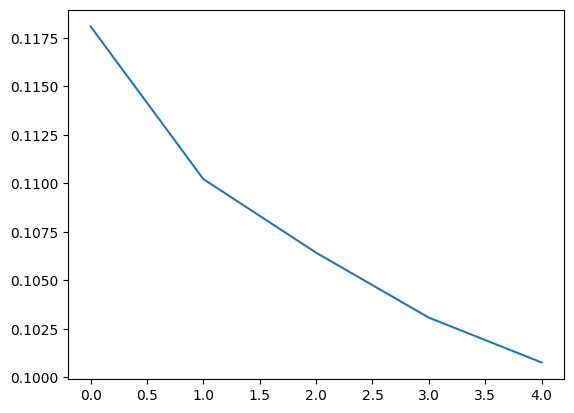

In [54]:
plt.plot([i for i in range (len(trainLosses))], trainLosses)
plt.show() 

# Train Accuracy

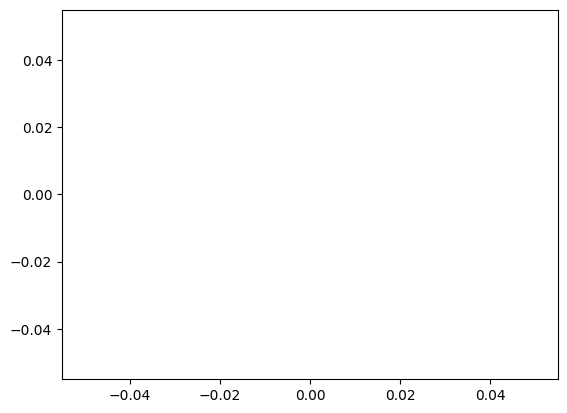

In [58]:
plt.plot([i for i in range(len(trainAcc))], trainAcc)
plt.show() 

# Val Error

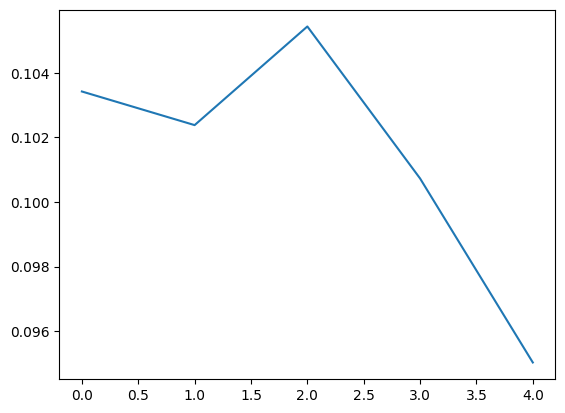

In [56]:
plt.plot([i for i in range(len(valLosses))], valLosses)
plt.show() 

# Val Accuracy

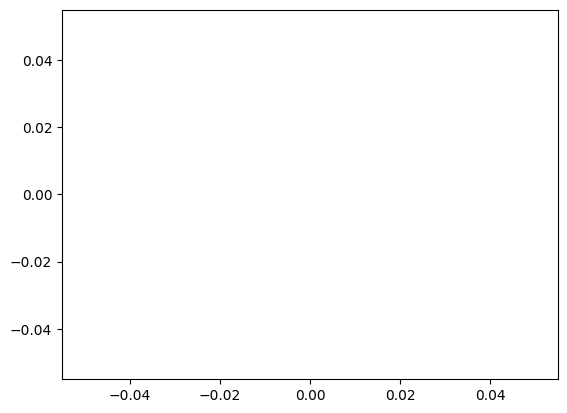

In [57]:
plt.plot([i for i in range(len(valAcc))], valAcc)
plt.show()

In [22]:
get_accuracy(test_loader, modelCNN)

Accuracy : 96.48%


In [24]:
get_accuracy(val_loader, modelCNN)

Accuracy : 96.43%


In [25]:
get_accuracy(train_loader, modelCNN)

Accuracy : 96.93%


In [34]:
 with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device).float()
            labels = labels.to(device)
            scores = modelCNN(data)

            print(scores.max(1))
            break

torch.return_types.max(
values=tensor([ 2.3875e-01,  1.9985e+00,  6.8113e-01,  6.0950e-01,  1.7919e+00,
         2.4835e+00,  7.2640e-01,  1.3447e+00, -3.8414e+00, -3.4523e+00,
         2.2077e+00, -4.5662e+00,  1.3987e+00,  9.3784e-01,  9.5058e-01,
         2.4251e+00,  2.6871e+00,  1.9580e+00,  2.1075e+00, -4.3607e+00,
         1.5680e+00, -7.6668e+00,  1.3155e+00,  3.9821e+00, -1.9543e+00,
        -1.8266e+00,  2.8702e+00, -3.4812e+00,  2.9122e+00,  9.0090e-01,
         1.3277e+00,  2.1543e+00,  1.5036e+00, -4.1737e-03,  2.5634e+00,
        -7.2916e-01, -6.9699e+00,  1.2473e+00, -2.6757e+00, -5.6872e+00,
         3.0560e+00, -6.2381e+00,  1.6421e+00, -4.3319e-01,  2.9116e+00,
        -1.0404e+00, -4.0889e-01,  8.6389e-01, -7.6575e+00,  8.4268e-01,
         2.5180e+00, -1.1871e+00,  6.3349e+00, -7.6148e-01, -8.3605e-01,
        -4.3994e-01, -2.9236e-01, -8.2250e+00,  7.8325e-01, -8.6006e-01,
         1.1681e+00,  1.8894e+00,  5.3732e+00,  3.4351e+00], device='cuda:0'),
indices=tensor

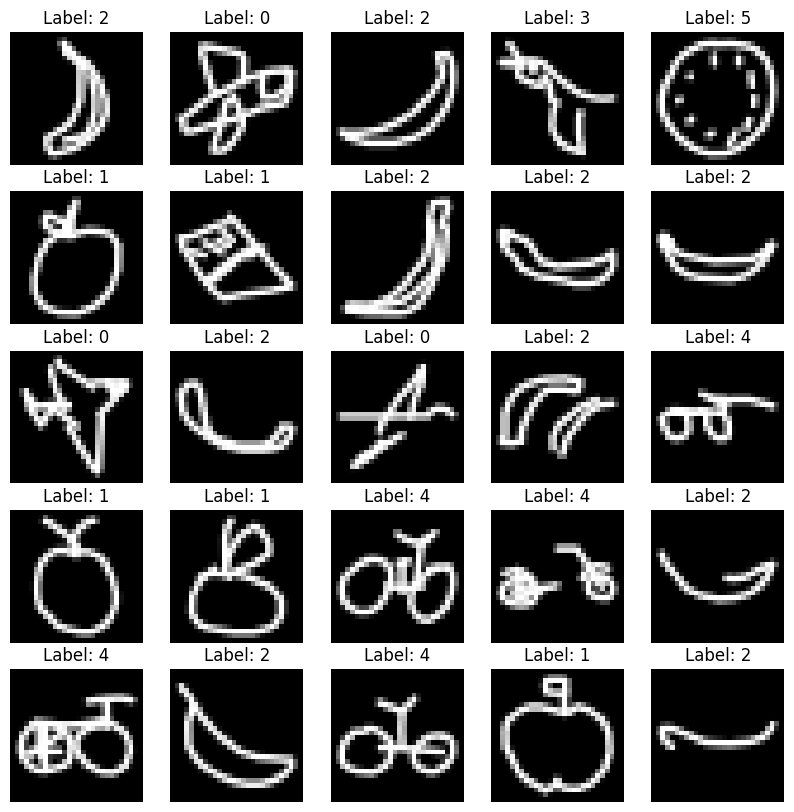

In [23]:
for images, labels in test_loader:
    plt.figure(figsize=(10, 10))
    for i in range(25):  
        image = images[i].squeeze(0).numpy()
        plt.subplot(5, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break
